In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_loss_over_tsteps, plot_exper_losses, plot_parm_loss_steps
from utils.plots import plot_qt_mode_hist, plot_qt_detailed_stats
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [(False, "run_20170629_15_06_49_metaV1_10ep_100ops_retrain_lr5e06_adam"), # quadratics
                  (False, "run_20170625_18_56_22_metaV1_60ep_100ops_retrain_lr5e06_adam"), # quadratics
                  (False, "run_20170629_16_58_08_metaV1_10ep_100ops_retrain_lr5e06_adam"), # 30eps/without BPTT
                  (False, "run_20170627_18_12_50_metaV1_10ep_100ops_retrain_lr1e06_adam"), # 30eps/with BPTT
                  # Meta V1 model regression
                  (True, "run_20170702_15_29_52_metaV1_40ep_100ops_retrain_lr5e06_adam"), # 110 epo
                  (False, "run_20170706_00_19_55_metaV3_80ep_100ops_lr5e05_adam"), # no fixed weights
                  # Meta V3 model regression with fixed geometric weights 
                  (True, "run_20170707_13_00_41_metaV3_20ep_100ops_retrain_lr5e06_adam"), # nu=0.1, 30 epochs
                  (True, "run_20170706_09_48_03_metaV3_80ep_100ops_lr5e05_adam"), # nu=0.98, 80 epochs
                  # ACT V2 model (1 LSTM)
                  (False, "run_20170706_17_38_38_actV2_100ep_100ops_lr5e06_adam"), # nu=0.1 100 epochs
                  (False, "run_20170701_18_28_48_actV2_50ep_100ops_retrain_lr5e06_adam"), # 0.5 100 epo
                  (False, "run_20170702_20_43_33_actV2_40ep_100ops_retrain_lr5e06_adam"), # 0.7 70+40epo
                  (False, "run_20170702_17_08_24_actV2_40ep_100ops_retrain_lr5e06_adam"),  # 0.80 / lr5e-6 / 110 eps
                  (False, "run_20170703_18_05_47_actV2_40ep_100ops_retrain_lr5e06_adam"), # q=0.90 / lr 1e-6 / 70eps
                  (False, "run_20170702_13_56_09_actV2_20ep_100ops_retrain_lr5e06_adam"), # 0.98 / lr5e-6 / 120eps
                  (False, "run_20170703_15_19_53_actV2_80ep_21ops_lr5e06_adam"), # 0.93 stochastic 80epos
                  (False, "run_20170707_11_00_09_actV1_20ep_21ops_retrain_lr5e06_adam"), # nu=0.93, 60epo
                  (False, "run_20170702_20_51_12_actV2_150ep_49ops_lr5e06_adam")] # 0.98 stochastic 



In [3]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.continue_prob,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model metaV1_regression_100ops / run_20170702_15_29_52_metaV1_40ep_100ops_retrain_lr5e06_adam
Using cuda for MetaLearner


INFO - INFO - loaded existing model from file logs/run_20170702_15_29_52_metaV1_40ep_100ops_retrain_lr5e06_adam/metaV1_regression_100ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170707_13_00_41_metaV3_20ep_100ops_retrain_lr5e06_adam/metaV3_regression_100ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170706_09_48_03_metaV3_80ep_100ops_lr5e05_adam/metaV3_regression_100ops.pkl


['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
1 Loading model metaV3_regression_100ops / run_20170707_13_00_41_metaV3_20ep_100ops_retrain_lr5e06_adam
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
2 Loading model metaV3_regression_100ops / run_20170706_09_48_03_metaV3_80ep_100ops_lr5e05_adam
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']


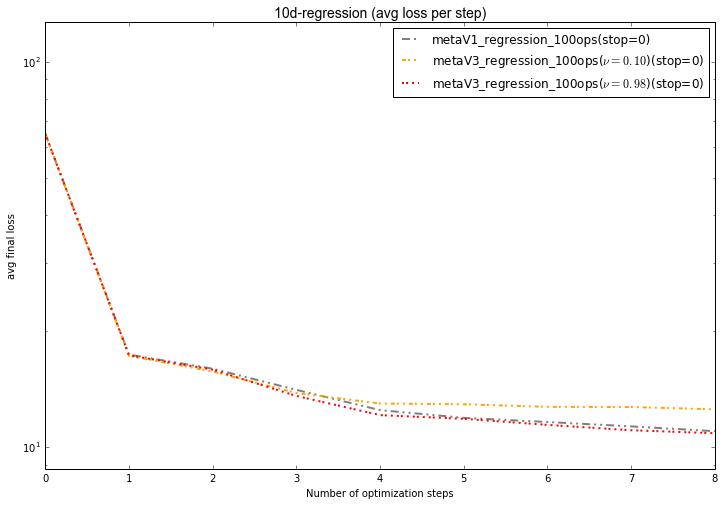

In [7]:
# new_exp_only = [new_experiments[5], new_experiments[6], new_experiments[7]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10_dim_compare_metaV1_V3_25steps", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=8,
                                              sort_exper="10d-regression",
                                              log_scale=True,
                                              with_stddev=False,
                                              runID=None)

In [ ]:
plot_qt_probs(experiments[1], data_set="train", show=True, plot_prior=False, save=True)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [2]:
val_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1.0, 
                             x_dim=10, use_cuda=True)
with open("data/val_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [4]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [87]:
with open("data/val_funcs_20000_10_1.0_10.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [6]:
test_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1., 
                             x_dim=10, use_cuda=True, calc_true_params=False)
with open("data/test_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [4]:
with open("data/test_funcs_20000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


In [5]:
print(len(new_experiments))
exp_idx = 2
max_steps = 100
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.continue_prob))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=True, save_run="test20000")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model actV1_regression_21ops with 20000 functions


3
Validating model actV1_regression_21ops with q-prob 0.930


INFO - INFO - Epoch 400, elapsed time 28.22 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 1.078e+03/9.627/0.438
INFO - INFO - Epoch 400: Final validation average ACT-loss: 10.66
INFO - INFO - Epoch 400: Average stopping-step: 20
INFO - INFO - Epoch 400: Final step losses: [ 64.786  17.755  16.227  14.457  12.88   12.028  11.639  11.397  11.151
  10.895  10.716  10.601  10.527  10.454  10.378  10.308  10.254  10.213
  10.178  10.145  10.114  10.086  10.063  10.042  10.023  10.005   9.989
   9.973   9.959   9.946   9.934   9.922   9.911   9.901   9.891   9.882
   9.873   9.864   9.856   9.848   9.841   9.834   9.827   9.82    9.814
   9.808   9.802   9.796   9.79    9.785   9.78    9.775   9.77    9.765
   9.76    9.756   9.751   9.747   9.743   9.739   9.735   9.731   9.727
   9.723   9.72    9.716   9.713   9.709   9.706   9.703   9.7     9.696
   9.693   9.69    9.688   9.685   9.682   9.679   9.676   9.674   9.671
   

INFO - Successfully saved experimental details to logs/run_20170707_11_00_09_actV1_20ep_21ops_retrain_lr5e06_adam/exp_statistics_test20000.dll


In [5]:
del new_experiments
new_experiments = []

for exper in expers_to_load:
    if exper[0]:
        new_experiments.append(get_experiment(path_to_exp=exper[1] + "/" + "exp_statistics_test20000.dll",
                                              full_path=True))
print("Ready")

Ready


In [16]:
del new_experiments[0]


('Key ', 100)
INFO - Successfully saved fig logs/run_20170707_11_00_09_actV1_20ep_21ops_retrain_lr5e06_adam/qt_T_dist_val_actV1_20ep_21ops_retrain.png


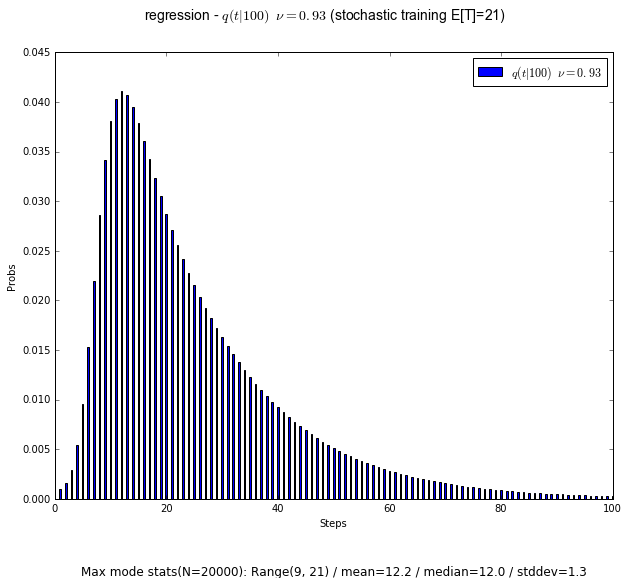

In [6]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

('key ', 100)


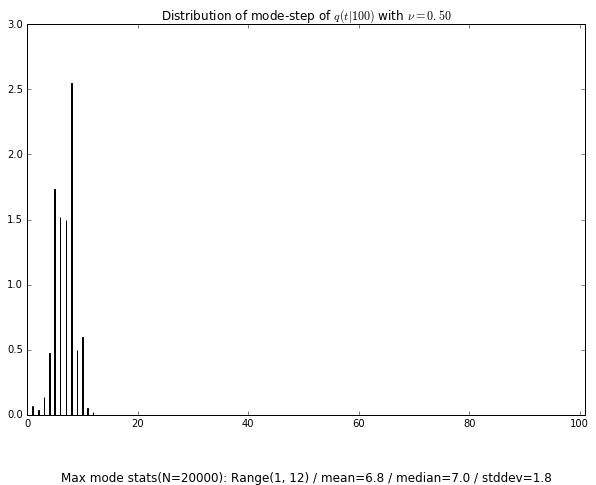

In [23]:
plot_qt_mode_hist(new_experiments[1], do_save=False, do_show=True, add_info=True)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


Run with key 100
INFO - Successfully saved fig logs/run_20170707_11_00_09_actV1_20ep_21ops_retrain_lr5e06_adam/qt_detailed_stats_actV1_20ep_21ops_retrain.png


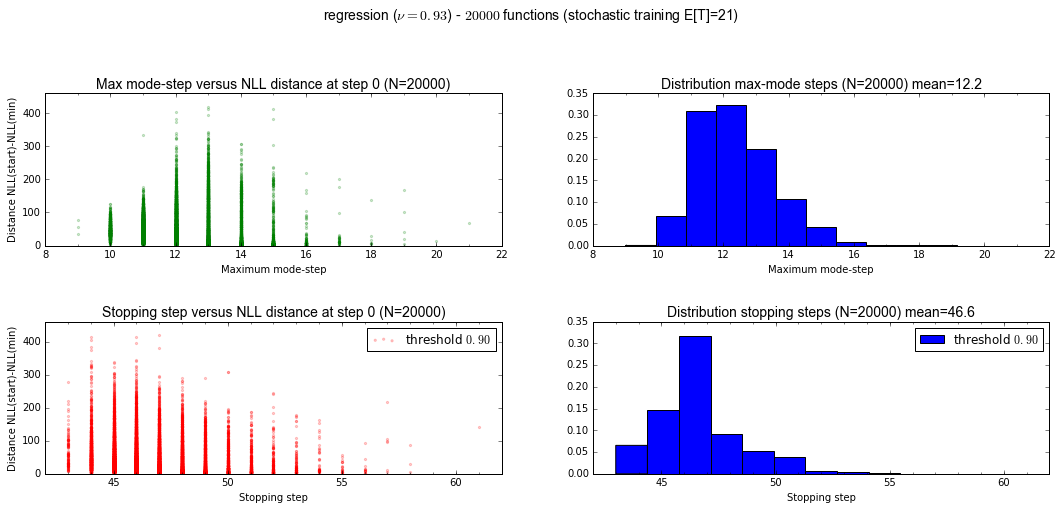

In [7]:
plot_qt_detailed_stats(new_experiments[2], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [9]:
# stops = np.cumsum(q_probs, 1)[:, -2] > threshold
q_probs = new_experiments[5].val_stats["qt_funcs"][100]
threshold = 0.95
stops = np.cumsum(q_probs, 1)[:, -2] > threshold

In [11]:
stops[0:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)